<a href="https://colab.research.google.com/github/Wally0924/Embedded-Systems/blob/main/tinyML/train_with_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFLite Training
https://github.com/liuyy3364/AAML_MCU_TinyML_Lab/blob/master/utils/train.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [2]:
#learning rate schedule
def lr_schedule(epoch):
  initial_learning_rate = 0.001
  decay_per_epoch = 0.99
  lrate = initial_learning_rate * (decay_per_epoch ** epoch)
  print('Learning rate = %f'%lrate)
  return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

#optimizer
optimizer = tf.keras.optimizers.Adam()

#define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

## load cifar10 data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train , 10)
y_test = to_categorical(y_test , 10)

170498071/170498071 [==============================] - 4s 0us/step


## show cifar 10 images

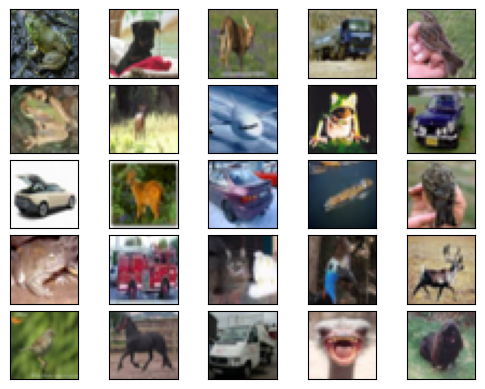

In [4]:
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
  for n in range(num_plot):
    idx = np.random.randint(0, x_train.shape[0])
    ax[m, n].imshow(x_train[idx])
    ax[m, n].get_xaxis().set_visible(False)
    ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()


## define model
https://github.com/mlcommons/tiny/blob/master/benchmark/training/image_classification/keras_model.py

In [5]:
def resnet_v1_eembc():
    # Resnet parameters
    input_shape=[32,32,3] # default size for cifar10
    num_classes=10 # default class number for cifar10
    num_filters = 16 # this should be 64 for an official resnet model

    # Input layer, change kernel size to 7x7 and strides to 2 for an official resnet
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x) # uncomment this for official resnet model


    # First stack

    # Weight layers
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    ##### add layer #######################
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    ##########################################
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Second stack

    # Weight layers
    num_filters = 32 # Filters need to be double for each stack
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Third stack

    # Weight layers
    num_filters = 64
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)

    # Final classification layer.
    pool_size = int(np.amin(x.shape[1:3]))
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# training

In [7]:
batch_size = 64
epochs = 10
save_model_name = "resnet_v1_eembc_add_layer"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


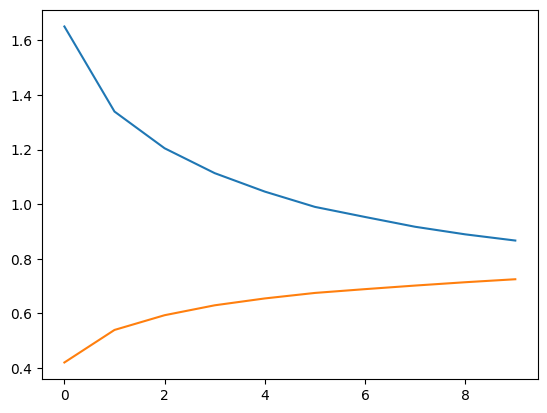

In [8]:
model = resnet_v1_eembc()
model.summary()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy', loss_weights=None,
    weighted_metrics=None, run_eagerly=None )

# fits the model on batches with real-time data augmentation:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size,
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=batch_size, subset='validation'),
         steps_per_epoch=len(x_train) * 0.8 / batch_size, epochs=epochs)

plt.plot(np.array(range(epochs)), History.history['loss'])
plt.plot(np.array(range(epochs)), History.history['accuracy'])
plt.savefig('train_loss_acc.png')
# model_name = "trainedResnet.h5"
model.save(f"trained_models/{save_model_name}.h5")

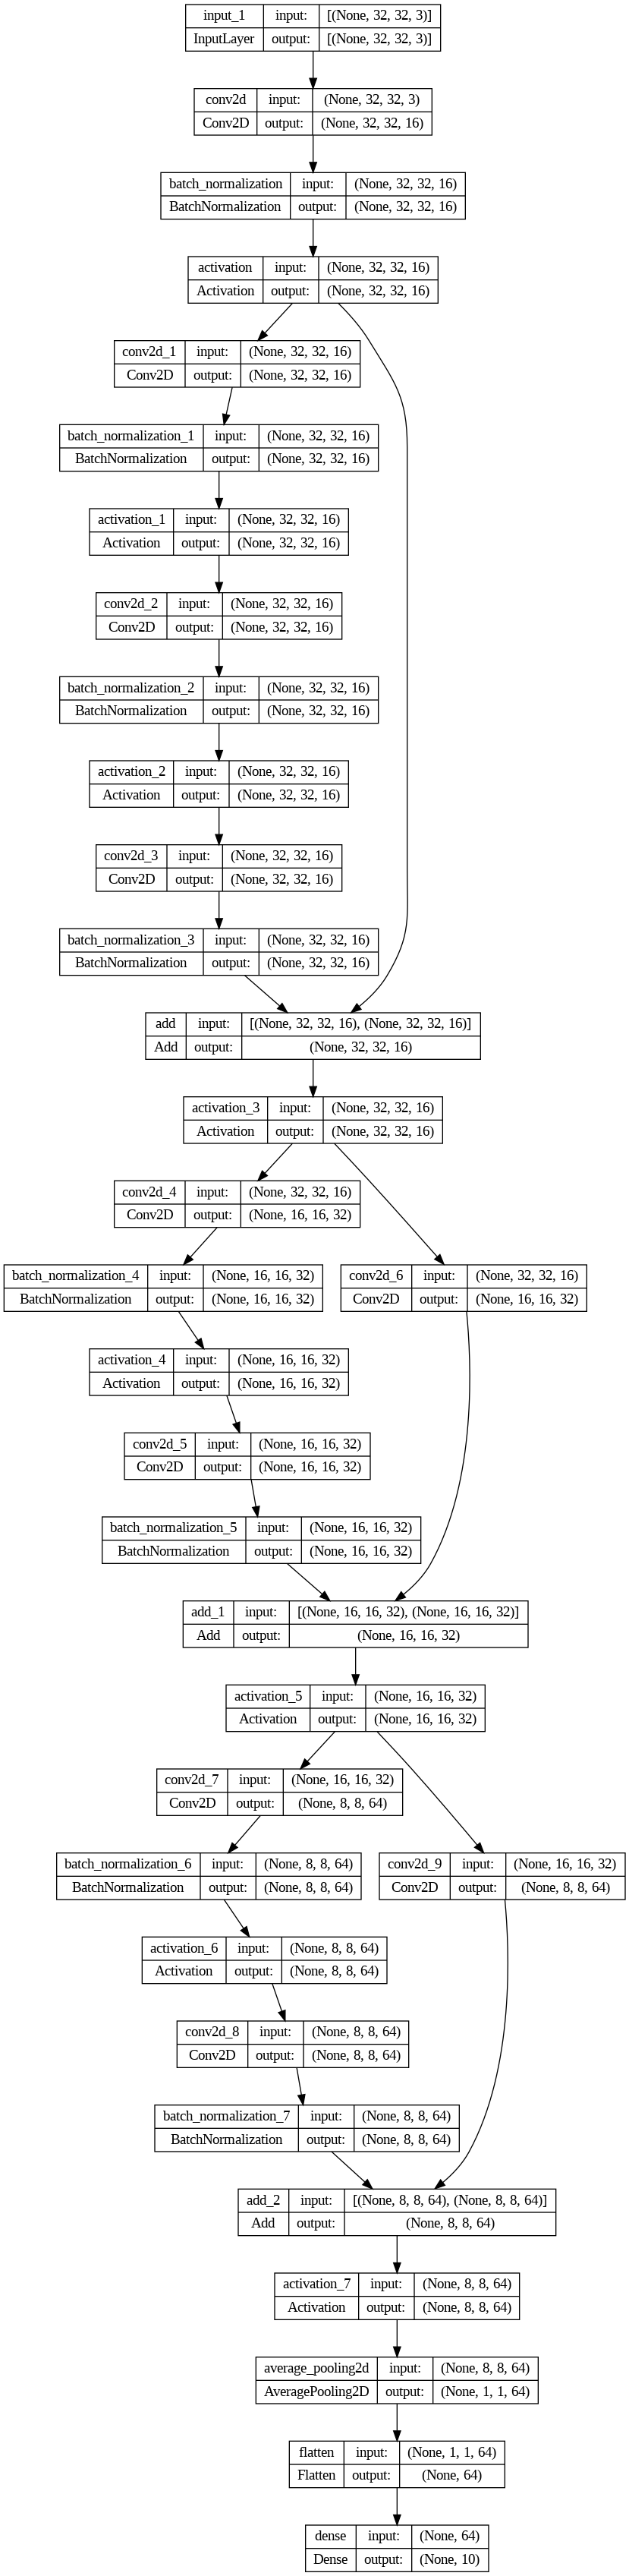

In [9]:
tf.keras.utils.plot_model(model , show_shapes=True , to_file=f"{save_model_name}.png")

In [10]:
!wget -O dog.jpg 'https://nextjournal.com/data/QmSAo4Nsf1fyxF79isKbaeF3f42LanxRyhUjwRd5SvFABA?content-type=image%2Fjpeg&filename=dog.jpg'

--2023-11-17 06:55:38--  https://nextjournal.com/data/QmSAo4Nsf1fyxF79isKbaeF3f42LanxRyhUjwRd5SvFABA?content-type=image%2Fjpeg&filename=dog.jpg
Resolving nextjournal.com (nextjournal.com)... 62.113.212.107
Connecting to nextjournal.com (nextjournal.com)|62.113.212.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660163 (645K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 644.69K   926KB/s    in 0.7s    

2023-11-17 06:55:39 (926 KB/s) - ‘dog.jpg’ saved [660163/660163]



In [11]:
from PIL import Image
img = np.array(Image.open("/content/dog.jpg").resize((32,32)))
pred = model.predict(np.expand_dims(img, axis=0))
print(pred)
print(np.argmax(pred))

1/1 [==============================] - 0s 390ms/step
[[1.2521392e-05 1.1902271e-06 8.9031499e-05 3.6600325e-03 2.9511817e-05
  9.9328738e-01 2.9039542e-05 2.7849767e-03 3.1644835e-05 7.4737814e-05]]
5


## export model to tflite


In [12]:
keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
open(f'{save_model_name}.tflite', 'wb').write(tflite_model)

328272

## export with quantization int8

In [13]:
def representative_dataset_generator():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  for i in range(3000):
    sample_img = np.expand_dims(np.array(x_train[i], dtype=np.float32), axis=0)
    yield [sample_img]

keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset_generator
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()
open(f'{save_model_name}_quant.tflite', 'wb').write(tflite_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


99280

## check model output

In [ ]:
data_input = np.expand_dims(img.astype(np.float32), axis=0)
data_input_quant = np.expand_dims(img, axis=0)

In [ ]:
# normal
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]
# img.astype(np.float32)
interpreter.set_tensor(input['index'], data_input)
interpreter.invoke()
print(interpreter.get_tensor(output['index']))
print(np.argmax(interpreter.get_tensor(output['index'])))

[[1.2863985e-04 2.6501411e-05 3.8594685e-02 2.2719713e-02 1.1470866e-02
  8.9464545e-01 8.0156764e-03 2.4022497e-02 2.2230705e-04 1.5382731e-04]]
5


In [ ]:
# quant
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]

interpreter.set_tensor(input['index'], data_input_quant)
interpreter.invoke()
print(interpreter.get_tensor(output['index']))
print(np.argmax(interpreter.get_tensor(output['index'])))

[[  0   0   7   6   2 233   2   6   0   0]]
5
